In [1]:
%reload_ext autoreload
%autoreload 2
import sys
import os
import importlib
sys.path.append("/Users/devenshidfar/Desktop/Masters/NRSC_510B/cebra_control_recal")
import cebra_utils
from cebra_utils import *
importlib.reload(cebra_utils)



<module 'cebra_utils' from '/Users/devenshidfar/Desktop/Masters/NRSC_510B/cebra_control_recal/cebra_utils.py'>

In [2]:
# Load data
file_path = '/Users/devenshidfar/Desktop/Masters/NRSC_510B/cebra_control_recal/mat_code_and_data/data/NN_opticflow_dataset.mat'
data = scipy.io.loadmat(file_path, squeeze_me=True, struct_as_record=False)
expt = data['expt']

print(expt.shape)

print(f"Experiment data type: {expt.dtype}")
print(f"Experiment data shape: {expt.shape}")

(65,)
Experiment data type: object
Experiment data shape: (65,)



Processing bin_size: 1 second(s)
Skipping session 1
Skipping session 2
Skipping session 3
Skipping session 4
Skipping session 5
Skipping session 6
Skipping session 7
Skipping session 8
Skipping session 9
Skipping session 10
Skipping session 11
Skipping session 12
Skipping session 13
Skipping session 14
Skipping session 15
Skipping session 16
Skipping session 17
Skipping session 18
Skipping session 19
Skipping session 20
Skipping session 21
Skipping session 22
Skipping session 23
Skipping session 24
Skipping session 25

Processing session 26/65
Rat: 883, Day: 9, Epoch: m1
Initial hippocampus angle binned: [1779.09885837 1807.90406977 1839.1042347  1861.82141295 1874.09809099
 1886.65959691 1913.90795797 1942.76081538 1955.35755773 1968.21489682
 1995.06687125 2021.57319062 2037.85188436 2044.80953674 2064.64316617
 2077.14963772 2101.87928529           nan           nan           nan]
NaN counts in hipp_angle_binned: 403
Empty bins: [  17   18   19   42   71   75   76   77   78   79   

Computing overlap:   0%|          | 0/45 [00:00<?, ?it/s]

Computing structure index..: 0.45


Computing shuffling:   0%|          | 0/10 [00:00<?, ?it/s]

Shuffling 99th percentile: 0.01
SI  is: 0.44802897946828946


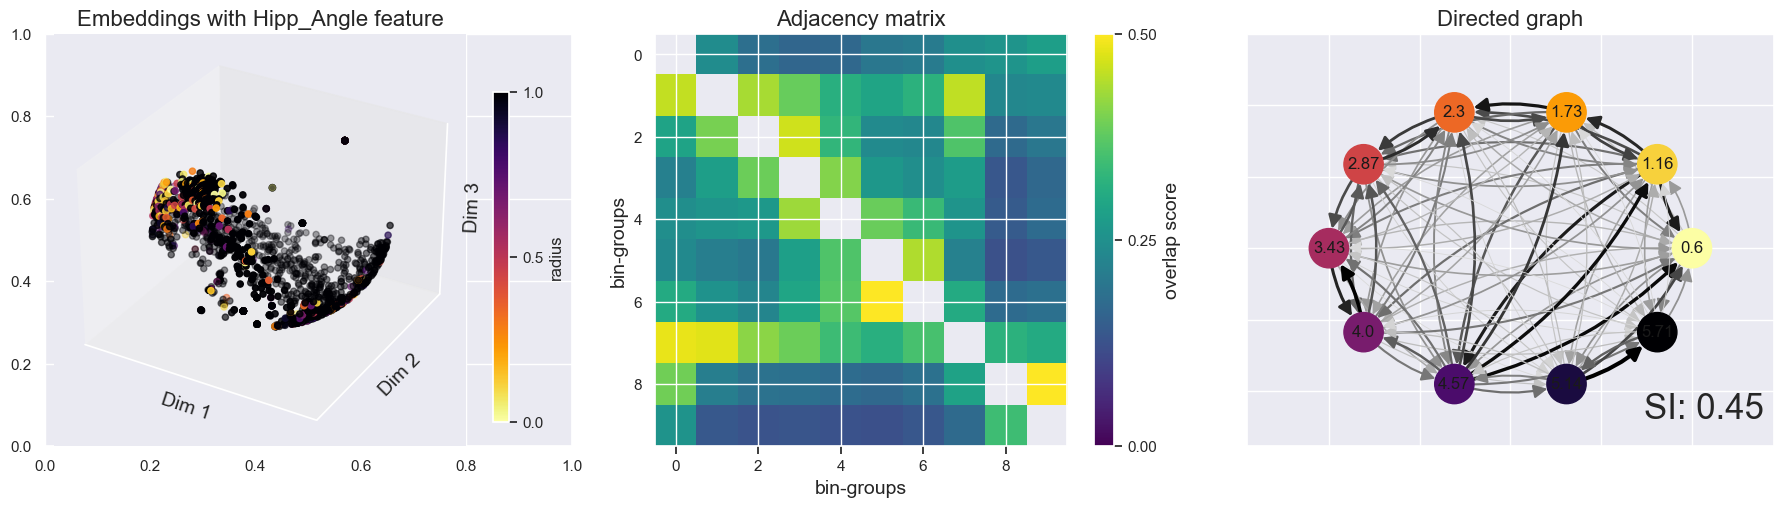

Computing bin-groups..: Done


Computing overlap:   0%|          | 0/45 [00:00<?, ?it/s]

Computing structure index..: 0.00


Computing shuffling:   0%|          | 0/10 [00:00<?, ?it/s]

Shuffling 99th percentile: 0.01
SI  is: 0.0


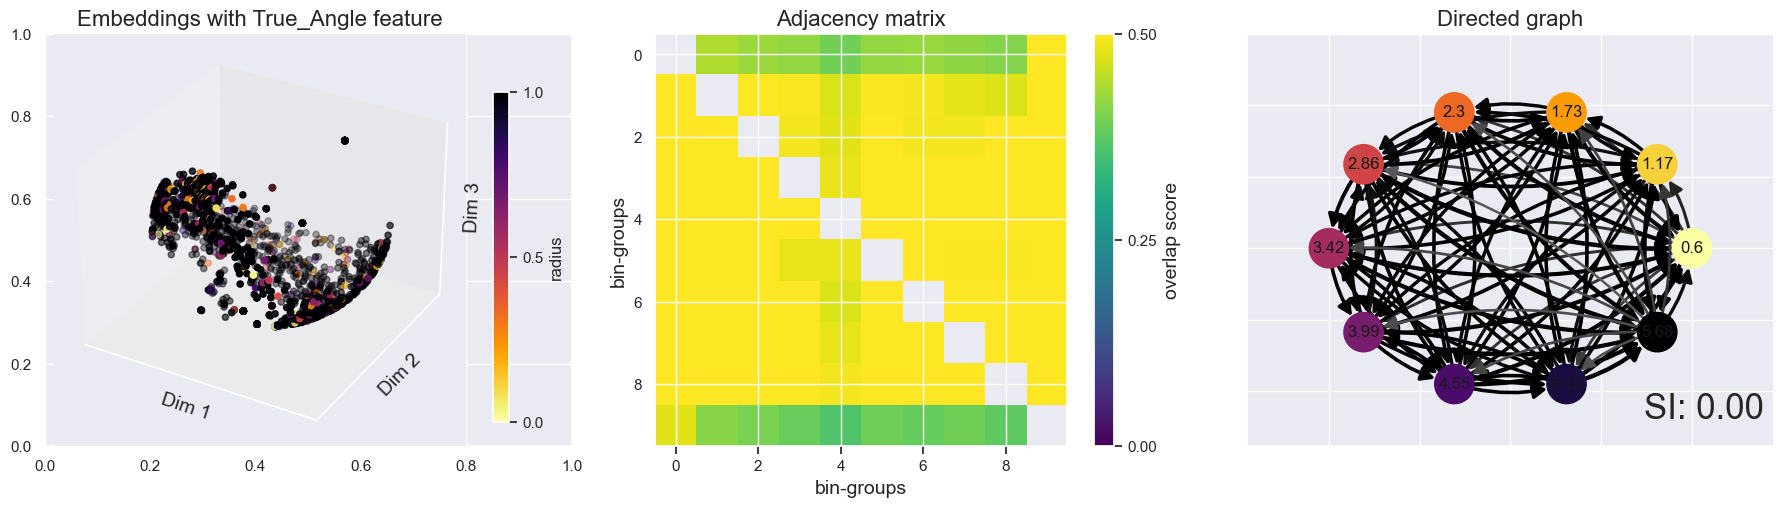

method: kmedoids
Doing K-Medoids initial clustering
cluster centers: [[-0.26915631 -0.6675722   0.69419187]
 [-0.22764766  0.49966899 -0.83576757]
 [-0.76511413  0.24966694 -0.5935207 ]
 [ 0.29338866 -0.8941772  -0.33818671]
 [-0.48415691 -0.08522612 -0.8708207 ]
 [ 0.66526747 -0.45378372 -0.59287393]
 [ 0.24114104  0.33896682 -0.90936929]
 [-0.95253044 -0.04860767 -0.300538  ]
 [ 0.50527787 -0.04551345 -0.86175573]
 [ 0.82481742  0.34311584 -0.44938579]
 [-0.61395848  0.53951979 -0.57617128]
 [-0.95431811 -0.2688624   0.1303459 ]
 [-0.72438014 -0.60363781  0.33300868]
 [ 0.23915258 -0.89312851  0.38095599]
 [ 0.37756377  0.54576629  0.74805403]]
Saved initial knots plot to /Users/devenshidfar/Desktop/Masters/NRSC_510B/cebra_control_recal/results/overlapped_bin/temperature_no_overlap/initial_knots_session_25.png
curr_fit_params: {'init_knots': array([[-0.95253044, -0.04860767, -0.300538  ],
       [-0.76511413,  0.24966694, -0.5935207 ],
       [-0.61395848,  0.53951979, -0.57617128],


TypeError: 'NoneType' object is not subscriptable

In [3]:
import os
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import umap
import pickle  # For saving filtered expt
import cebra

# config Parameters
num_trials = 40
control_point = 41
control_count = 0

model_save_path = '/Users/devenshidfar/Desktop/Masters/NRSC_510B/cebra_control_recal/models'


# Set to 1 to save the models and animations
save_models = 1
save_anim = 1
load_npy = 0
rm_outliers = True


# Define bin sizes (in seconds)
bin_sizes = [1]  # You can add more bin sizes if needed

# Initialize lists to store embeddings and metadata
embeddings_list = []
metadata_list = []

# Define velocity threshold
vel_threshold = 5 # degrees per second

# Main Processing Loop
for bin_size in bin_sizes:
    print(f"\nProcessing bin_size: {bin_size} second(s)")

    for session_idx, session in enumerate(expt):
        control_count += 1

        # Control Session Skipping
        if control_count <= control_point:
            print(f"Skipping session {session_idx + 1}")
            continue 
        elif control_count > control_point + num_trials:
            print("Reached the desired number of trials. Exiting session loop.")
            break

        print(f"\nProcessing session {session_idx + 1}/{len(expt)}")
        print(f"Rat: {session.rat}, Day: {session.day}, Epoch: {session.epoch}")

        ros_data = session.rosdata

        start_time = ros_data.startTs
        end_time = ros_data.stopTs

        # Convert encTimes to seconds
        enc_times = np.array(ros_data.encTimes-start_time) / 1e6  # Convert to seconds
        vel = np.array(ros_data.vel)

        # Ensure enc_times and vel are valid
        valid_idx = np.isfinite(enc_times) & np.isfinite(vel)
        enc_times = enc_times[valid_idx]
        vel = vel[valid_idx]

        # Get indices where vel > vel_threshold
        high_vel_idx = vel > vel_threshold

        if np.sum(high_vel_idx) == 0:
            print("No data points where vel > vel_threshold. Skipping session.")
            continue

        # Filter enc_times and behavioral variables
        enc_times_high_vel = enc_times[high_vel_idx]
        high_vel = vel[high_vel_idx]
        est_gain = np.array(ros_data.estGain)[valid_idx][high_vel_idx]
        hipp_angle = np.array(ros_data.hippAngle)[valid_idx][high_vel_idx]
        true_angle = np.array(ros_data.encAngle)[valid_idx][high_vel_idx]

        # Define bins over enc_times_high_vel
        bins = np.arange(enc_times_high_vel[0], enc_times_high_vel[-1] + bin_size, bin_size)

        if len(bins) < 2:
            print("Not enough data after filtering for high velocity. Skipping session.")
            continue

        # Bin behavioral variables
        est_gain_binned, _, _ = stats.binned_statistic(enc_times_high_vel, est_gain, statistic='mean', bins=bins)
        hipp_angle_binned, _, _ = stats.binned_statistic(enc_times_high_vel, hipp_angle, statistic='mean', bins=bins)
        true_angle_binned, _, _ = stats.binned_statistic(enc_times_high_vel, true_angle, statistic='mean', bins=bins)
        high_vel_binned, _, _ = stats.binned_statistic(enc_times_high_vel, high_vel, statistic='mean', bins=bins)

        # Check for NaNs in binned data
        print(f"Initial hippocampus angle binned: {hipp_angle_binned[:20]}")
        print("NaN counts in hipp_angle_binned:", np.isnan(hipp_angle_binned).sum())
        print("Empty bins:", np.where(np.isnan(hipp_angle_binned))[0])


        # #remove NaN bins
        # valid_bins = ~np.isnan(hipp_angle_binned)
        # hipp_angle_binned = hipp_angle_binned[valid_bins]
        # est_gain_binned = est_gain_binned[valid_bins]
        # true_angle_binned = true_angle_binned[valid_bins]
        # high_vel_binned = high_vel_binned[valid_bins]

        # Filter Spike Times Based on High Velocity
        
        all_spikes = []
        skipped_clusters = 0

        for cluster in session.clust:
            if cluster.isolationQuality > 3:
                print(f"Skipping cluster {cluster.name} due to low isolation quality ({cluster.isolationQuality})") #done in Madhav et al., 2024
                skipped_clusters += 1
                continue


            spike_times_sec = (cluster.ts - start_time) / 1e6  # Convert to seconds

            # vel_at_spikes = np.interp(spike_times_sec, enc_times, vel)
            vel_at_spikes = cluster.vel
    

            # Include spikes where vel_at_spikes > vel_threshold
            include_spikes = vel_at_spikes > vel_threshold
            spike_times_sec_high_vel = spike_times_sec[include_spikes]

            if len(spike_times_sec_high_vel) == 0:
                print(f"No spikes for cluster {cluster.name} at high velocities. Skipping cluster.")
                continue

            # Bin spikes
            binned_spikes, _, _ = stats.binned_statistic(spike_times_sec_high_vel, np.ones_like(spike_times_sec_high_vel), statistic='sum', bins=bins)
            # Bin behavioural vars
            binned_hipp_angle, _, _ = stats.binned_statistic(spike_times_sec_high_vel, cluster.hippAngle, statistic='mean', bins=bins)
            binned_true_angle, _, _ = stats.binned_statistic(spike_times_sec_high_vel, cluster.encAngle, statistic='mean', bins=bins)
            binned_high_vel, _, _ = stats.binned_statistic(spike_times_sec_high_vel, cluster.vel, statistic='mean', bins=bins)

            all_spikes.append(binned_spikes)

        if not all_spikes:
            print("No valid spike data after filtering. Skipping session.")
            continue

        # Assemble neural data
        neural_data = np.array(all_spikes).T  # Shape: (num_bins, num_clusters)

        # Consistency Check Between Bins
        num_bins_neural = neural_data.shape[0]
        num_bins_behavior = len(est_gain_binned)

        if num_bins_neural != num_bins_behavior:
            print(f"Warning: Number of neural data bins ({num_bins_neural}) does not match behavioral data bins ({num_bins_behavior}). Adjusting to minimum.")
            min_bins = min(num_bins_neural, num_bins_behavior)
            neural_data = neural_data[:min_bins, :]
            est_gain_binned = est_gain_binned[:min_bins]
            #This Changed!!!!
            # hipp_angle_binned = hipp_angle_binned[:min_bins] * ((2*np.pi)/360)
            # true_angle_binned = true_angle_binned[:min_bins] * ((2*np.pi)/360)
            hipp_angle_binned_unwrap = binned_hipp_angle[:min_bins] * ((2*np.pi)/360)
            true_angle_binned_unwrap = binned_true_angle[:min_bins] * ((2*np.pi)/360)

            # hipp_angle_binned = binned_hipp_angle[:min_bins] * ((2*np.pi)/360)
            # true_angle_binned = binned_true_angle[:min_bins] * ((2*np.pi)/360)

            high_vel_binned = binned_high_vel

            bins = bins[:min_bins+1]

   
        embeddings_2d_list = []
        embeddings_3d_list = []

        embedding_filename_2d = f"bin_size-{bin_size}_embeddings_2d_rat{session.rat}_day{session.day}_epoch{session.epoch}.npy"
        embedding_filename_3d = f"bin_size-{bin_size}_embeddings_3d_rat{session.rat}_day{session.day}_epoch{session.epoch}.npy"

        # if load_npy == 1: #NOT WORKING
        #     # Load embeddings data from .npy files as numpy arrays
        #     embeddings_2d_data = np.load(os.path.join(model_save_path, embedding_filename_2d))
        #     embeddings_3d_data = np.load(os.path.join(model_save_path, embedding_filename_3d))
        #     print(f"Loaded embeddings data from: {embedding_filename_2d}, {embedding_filename_3d}")

        # else:
        #     # Apply CEBRA in 2D and 3D
        temperature = ['no_overlap']
        for temp in temperature:
            results_save_path = f'/Users/devenshidfar/Desktop/Masters/NRSC_510B/cebra_control_recal/results/overlapped_bin/temperature_{temp}'
            anim_save_path = f'{results_save_path}/3d_animations'
            time_dist_save_path = f'{results_save_path}/time_dist_plot'
            SI_save_path = f'{results_save_path}/SI_Plots'
            param_plot_path = f'{results_save_path}/Param_Plots'
            # Create necessary directories
            os.makedirs(results_save_path, exist_ok=True)
            os.makedirs(model_save_path, exist_ok=True)
            os.makedirs(anim_save_path, exist_ok=True)
            os.makedirs(SI_save_path, exist_ok=True)
            os.makedirs(param_plot_path, exist_ok=True)


            embeddings_2d = apply_cebra(neural_data, 2)
            embeddings_3d = apply_cebra(neural_data, 3)

            print(f"Output embeddings_2d shape before nt_TDA and mask: {embeddings_2d.shape}")
            print(f"Output embeddings_3d shape before nt_TDA and mask: {embeddings_3d.shape}")

            nan_mask_3d = (
                ~np.isnan(embeddings_3d).any(axis=1) &
                ~np.isnan(hipp_angle_binned) &
                ~np.isnan(true_angle_binned) &
                ~np.isnan(est_gain_binned) &
                ~np.isnan(high_vel_binned)
            )

            #embeddings_2d = embeddings_2d[nan_mask, :]
            embeddings_3d = embeddings_3d[nan_mask_3d, :]
            hipp_angle_binned_unwrap = hipp_angle_binned[nan_mask_3d]
            true_angle_binned_unwrap = true_angle_binned[nan_mask_3d]
            hipp_angle_binned = hipp_angle_binned[nan_mask_3d]
            true_angle_binned = true_angle_binned[nan_mask_3d]
            est_gain_binned = est_gain_binned[nan_mask_3d]
            high_vel_binned = high_vel_binned[nan_mask_3d]

            print(f"Output embeddings_2d shape before nt_TDA and after nan mask: {embeddings_2d.shape}")
            print(f"Output embeddings_3d shape before nt_TDA and after nan mask: {embeddings_3d.shape}")

            if(rm_outliers == True):
                print("removing outliers...")
                inlier_indices_2d = nt_TDA(embeddings_2d)
                inlier_indices_3d = nt_TDA(embeddings_3d)
                embeddings_2d = embeddings_2d[inlier_indices_2d,:]
                embeddings_3d = embeddings_3d[inlier_indices_3d,:]
                hipp_angle_binned_3d_unwrap = hipp_angle_binned_unwrap[inlier_indices_3d] 
                true_angle_binned_3d_unwrap = true_angle_binned_unwrap[inlier_indices_3d]
                hipp_angle_binned_3d = hipp_angle_binned[inlier_indices_3d] 
                true_angle_binned_3d = true_angle_binned[inlier_indices_3d]
                est_gain_binned_3d = est_gain_binned[inlier_indices_3d]
                high_vel_binned = high_vel_binned[inlier_indices_3d]
            print(f"Output embeddings_2d shape after nt_TDA and nan mask: {embeddings_2d.shape}")
            print(f"Output embeddings_3d shape after nt_TDA and nan mask: {embeddings_3d.shape}")

            print(f"est_gain_binned_3d: {est_gain_binned_3d[100:130]}")

            #put true and hipp angles in rad and wrap

            hipp_angle_binned_3d = ((hipp_angle_binned_3d * ((2*np.pi)/360)) % (2*np.pi))
            true_angle_binned_3d = ((true_angle_binned_3d * ((2*np.pi)/360)) % (2*np.pi))

            embeddings_2d_list.append(embeddings_2d)
            embeddings_3d_list.append(embeddings_3d)

            # Fit principal curves (adapted from Chaudhuri et al.)
            print(f" hippocampal angle: {hipp_angle_binned_3d[50:100]})")


            #COMPUTE SI

            SI_params = {
                'n_bins': 10,
                'n_neighbors': 15,
                'discrete_label': False,
                'num_shuffles': 10,
                'verbose': True,
            }

            SI_score_hipp = compute_SI_and_plot(embeddings=embeddings_3d,behav_var=hipp_angle_binned_3d,params=SI_params,behav_var_name='Hipp_Angle',save_dir=SI_save_path,session_idx=session_idx)
            SI_score_true = compute_SI_and_plot(embeddings=embeddings_3d,behav_var=true_angle_binned_3d,params=SI_params,behav_var_name='True_Angle',save_dir=SI_save_path,session_idx=session_idx)


            penalty_types = ['curvature']
            curvature_coeffs = [5]

            for penalty_type in penalty_types:
                for curv in curvature_coeffs:
            
                    fit_params = {
                        'dalpha': 0.005,
                        'knot_order': 'nearest',
                        'penalty_type': penalty_type, #note that curvature penalty penalizes both curvature and length * len_coeff
                        'nKnots': 15,
                        'curvature_coeff': curv,
                        'len_coeff': 2,
                        'density_coeff': 2,
                        'delta': 0.1
                    }
                    # principal_curve_2d, principal_curve_2d_pre, curve_params_2d, decoded_angles_2d, mse_2d = fit_spud_to_cebra(embeddings_2d,ref_angles=hipp_angle_binned,hippocampal_angle_origin=0, session_idx=session_idx,session=session,results_save_path=results_save_path,dimension_3d=0)
                    
                    principal_curve_3d, principal_curve_3d_pre, curve_params_3d = fit_spud_to_cebra(embeddings_3d,ref_angle=true_angle_binned_3d[3], 
                                                                                                                               session_idx=session_idx,session=session,results_save_path=results_save_path,
                                                                                                                               fit_params=fit_params,dimension_3d=1,verbose=False)


                    # # Interpolate the principal curves (for calculating dists between the embedding points and princ curve)
                    # interpolated_curve_2d = interpolate_principal_curve(principal_curve_2d, points_per_unit_distance=10)
                    # interpolated_curve_3d = interpolate_principal_curve(principal_curve_3d, points_per_unit_distance=10)

                    # Plot time vs distance from the spline to the point

                    # plot_time_vs_distance(
                    #     embeddings=embeddings_2d,
                    #     principal_curve=interpolated_curve_2d,
                    #     times=bins[:-1] + bin_size / 2,  x_axis_var="Times",
                    #     annotate_var=high_vel_binned, annotate_var_name="Velocity",
                    #     session=session, session_idx=session_idx,
                    #     bin_size=bin_size,
                    #     save_path=time_dist_save_path,
                    #     dimension = "2"
                    # )

                    # plot_time_vs_distance(
                    #     embeddings=embeddings_3d,
                    #     principal_curve=interpolated_curve_3d,
                    #     times=bins[:-1] + bin_size / 2,  x_axis_var="Times",
                    #     annotate_var=high_vel_binned, annotate_var_name="Velocity",
                    #     session=session, session_idx=session_idx,
                    #     bin_size=bin_size,
                    #     save_path=time_dist_save_path,
                    #     dimension = "3"
                    # )

                    # plot_time_vs_distance(
                    #     embeddings=embeddings_2d,
                    #     principal_curve=interpolated_curve_2d,
                    #     times=high_vel_binned, x_axis_var = "Velocity)",
                    #     annotate_var=high_vel_binned, annotate_var_name="None",
                    #     session=session, session_idx=session_idx,
                    #     bin_size=bin_size,
                    #     save_path=time_dist_save_path,
                    #     dimension = "2"
                    # )

                    # plot_time_vs_distance(
                    #     embeddings=embeddings_2d,
                    #     principal_curve=interpolated_curve_2d,
                    #     times=high_vel_binned, x_axis_var = "Velocity",
                    #     annotate_var=high_vel_binned, annotate_var_name="None",
                    #     session=session, session_idx=session_idx,
                    #     bin_size=bin_size,
                    #     save_path=time_dist_save_path,
                    #     dimension = "3"
                    # )

                    # run_persistent_homology(
                    #     embeddings=embeddings_2d,
                    #     session_idx=session_idx,
                    #     session=session,
                    #     results_save_path=results_save_path,
                    #     dimension=2
                    # )

                    # # Run persistent homology on 3D embeddings
                    # run_persistent_homology(
                    #     embeddings=embeddings_3d,
                    #     session_idx=session_idx,
                    #     session=session,
                    #     results_save_path=results_save_path,
                    #     dimension=3
                    # )

                    #UMAP and TSNE vis
                    #umap_and_tSNE_vis(neural_data=neural_data,embeddings_2d=embeddings_2d,embeddings_3d=embeddings_3d,hipp_angle_binned=hipp_angle_binned,true_angle_binned=true_angle_binned,principal_curve_2d=principal_curve_2d,principal_curve_3d=principal_curve_3d,session=session,session_idx=session_idx,results_save_path=results_save_path)

                    # Create rotating 3D plots
                    anim_save_file = f"{anim_save_path}/bin_size-{bin_size}/session_{session_idx}/vel_thresh_{vel_threshold}/curv_{curv}_pen_type_{penalty_type}/"
                    os.makedirs(anim_save_file,exist_ok=True)

                    # create_rotating_3d_plot(dense_points, session, (hipp_angle_binned % 360), "hipp angle dense", anim_save_file, save_anim, principal_curve_3d,tt=curve_params_3d,num_labels=20)

                    print(f"curve_params shape: {curve_params_3d.shape}")
                    print(f"curve_params values first 20: {curve_params_3d[:20]}")

                    print(f"hipp_angle_binned shape: {hipp_angle_binned_3d.shape}")
                    print(f"hipp_angle values first 20: {hipp_angle_binned_3d[:20]}")

                    print(f"DIFFFFFF: {np.std(np.diff(curve_params_3d))}")

                    mean_dist_to_princ = dist_tot_to_princ_curve(embeddings=embeddings_3d,principal_curve=principal_curve_3d)
                    shuffled_hipp_angle_binned_3d = np.random.permutation(hipp_angle_binned_3d)
                    angle_diff, decoded_angles, mse_decode_true = calculate_average_difference_in_decoded_hipp_angle(embeddings_3d, principal_curve=principal_curve_3d, tt=curve_params_3d, actual_angles=hipp_angle_binned_3d)
                    shuffled_angle_diff, shuffled_decoded_angles, shuffled_mse_decode_true = calculate_average_difference_in_decoded_hipp_angle(embeddings_3d, principal_curve=principal_curve_3d, tt=curve_params_3d, actual_angles=shuffled_hipp_angle_binned_3d)
                    mean_decode_true = np.mean(angle_diff)
                    shuffled_mean_decode_true = np.mean(shuffled_angle_diff)

                    plot_decoded_var_and_true(decoded_var=decoded_angles, behav_var=hipp_angle_binned_3d, 
                              xlabel='Parametrization (0 to 1)', 
                              ylabel1='Decoded Variable', 
                              ylabel2='Behavioral Variable', 
                              title='Decoded and Behavioral Variable Plot', 
                              legend_labels=['Decoded Variable', 'Behavioral Variable'],
                              save_path=param_plot_path,
                              figsize=(12, 6),
                              session_idx=session_idx,
                              behav_var_name='Hipp_Angle')

                    print(f"mse vs mean true : {mse_decode_true} vs. {mean_decode_true}")
                    print(f"shuffled mse vs mean true : {shuffled_mse_decode_true} vs. {shuffled_mean_decode_true}")
                    print(f"angle_diff random 10 is: {angle_diff[20:30]}")
                    compare_angles = np.column_stack((shuffled_hipp_angle_binned_3d,hipp_angle_binned_3d,decoded_angles))
                    print(f"compare angle random 10 is: {compare_angles[20:30]}")
                    create_rotating_3d_plot(embeddings_3d=embeddings_3d, session=session, behav_var=hipp_angle_binned_3d, name_behav_var="hipp angle", anim_save_path=anim_save_file, save_anim=save_anim, principal_curve=principal_curve_3d, tt=curve_params_3d, num_labels=20, mean_dist=mean_dist_to_princ,avg_angle_diff=mean_decode_true,shuffled_avg_angle_diff=shuffled_mean_decode_true)
                    # create_rotating_3d_plot(embeddings_3d, session, (hipp_angle_binned_3d % 360), "hipp angle", anim_save_file, save_anim,principal_curve=principal_curve_3d)
                    # create_rotating_3d_plot(embeddings_3d, session, hipp_angle_binned % 360, "hipp angle pre", anim_save_file, save_anim, principal_curve_3d_pre)
                    # create_rotating_3d_plot(embeddings_3d, session, true_angle_binned % 360, "true angle", anim_save_file, save_anim, principal_curve_3d)
                    # create_rotating_3d_plot(embeddings_3d, session, high_vel_binned, "velocity", anim_save_file, save_anim, principal_curve_3d)
                    print(f"Created rotating 3D plots for session {session_idx}.")


            # decode_H = calculate_over_experiment_H(embeddings=embeddings_3d,tt=curve_params_3d,principal_curve=principal_curve_3d,true_angle=true_angle_binned_3d, num_avg_over=1, spacing=10, n_neighbors=20)
            # decode_H_30 = calculate_over_experiment_H(embeddings=embeddings_3d,tt=curve_params_3d,principal_curve=principal_curve_3d,true_angle=true_angle_binned_3d, num_avg_over=1, spacing=20, n_neighbors=20)
            # decode_H_50 = calculate_over_experiment_H(embeddings=embeddings_3d,tt=curve_params_3d,principal_curve=principal_curve_3d,true_angle=true_angle_binned_3d, num_avg_over=1, spacing=60, n_neighbors=20)
            # For decode_H

            decode_H = calculate_over_experiment_H_array(decoded_angles=decoded_angles,true_angles=true_angle_binned_3d,spacing=1)
            decode_H_10 = calculate_over_experiment_H_array(decoded_angles=decoded_angles,true_angles=true_angle_binned_3d,spacing=10)
            decode_H_20 = calculate_over_experiment_H_array(decoded_angles=decoded_angles,true_angles=true_angle_binned_3d,spacing=20)
            decode_H_shuffled_10 = calculate_over_experiment_H_array(decoded_angles=shuffled_decoded_angles,true_angles=true_angle_binned_3d,spacing=10)
            print(f"decode_H is: {decode_H[10:30]}")

            decode_H_nan_count = np.isnan(decode_H).sum()
            decode_H_nan_indices = np.where(np.isnan(decode_H))[0]

            # For est_gain_binned_3d
            est_gain_nan_count = np.isnan(est_gain_binned_3d).sum()
            est_gain_nan_indices = np.where(np.isnan(est_gain_binned_3d))[0]

            # Print results
            print(f"Mean of decode H (ignoring NaNs): {np.nanmean(decode_H)}")
            print(f"Mean of est gain H (ignoring NaNs): {np.nanmean(est_gain_binned_3d)}")

            print(f"Number of NaNs in decode H: {decode_H_nan_count}")
            print(f"Indices of NaNs in decode H: {decode_H_nan_indices}")

            print(f"Number of NaNs in est gain H: {est_gain_nan_count}")
            print(f"Indices of NaNs in est gain H: {est_gain_nan_indices}")

            decode_H = np.clip(decode_H, -2, 2)
            decode_H_10 = np.clip(decode_H_10, -2, 2)
            decode_H_20 = np.clip(decode_H_20, -2, 2)
            decode_H_shuffled_10 =  np.clip(decode_H_shuffled_10, -2, 2)

            min_len_1 = min(len(est_gain_binned_3d), len(decode_H))
            min_len_10 = min(len(est_gain_binned_3d), len(decode_H_10))
            min_len_20 = min(len(est_gain_binned_3d), len(decode_H_20))

            mean_H_1_diff = np.mean(np.abs(est_gain_binned_3d[:min_len_1] - decode_H[:min_len_1]))
            mean_H_10_diff = np.mean(np.abs(est_gain_binned_3d[:min_len_10] - decode_H_10[:min_len_10]))
            mean_H_20_diff = np.mean(np.abs(est_gain_binned_3d[:min_len_20] - decode_H_20[:min_len_20]))

            std_H_1_diff = np.std(est_gain_binned_3d[:min_len_1] - decode_H[:min_len_1])
            std_H_10_diff = np.std(est_gain_binned_3d[:min_len_10] - decode_H_10[:min_len_10])
            std_H_20_diff = np.std(est_gain_binned_3d[:min_len_20] - decode_H_20[:min_len_20])


            print(f"H decode length: {np.shape(decode_H)}")
            print(f"H est length: {np.shape(est_gain_binned_3d)}")
            print(f"tru_angle_binned unwrap length: {np.shape(true_angle_binned_3d_unwrap)}")

            lap_number, sorted_H_decode, sorted_lap_number = get_H_over_lap(H=decode_H,true_angle=true_angle_binned_3d_unwrap)
            _, sorted_H_est, _ = get_H_over_lap(H=est_gain_binned_3d,true_angle=true_angle_binned_3d_unwrap)

            lap_number, sorted_H_decode_10, sorted_lap_number_10 = get_H_over_lap(H=decode_H_10,true_angle=true_angle_binned_3d_unwrap)

            lap_number, sorted_H_decode_20, sorted_lap_number_20 = get_H_over_lap(H=decode_H_20,true_angle=true_angle_binned_3d_unwrap)

            lap_number, sorted_H_decode_shuffled_20, sorted_lap_number_shuffled_20 = get_H_over_lap(H=decode_H_shuffled_10,true_angle=true_angle_binned_3d_unwrap)

            print(f"sorted lap number: {np.max(sorted_lap_number)-np.min(sorted_lap_number)}")
            print(f"max lap number: {np.max(sorted_lap_number)}")
            print(f"min lap number: {np.min(sorted_lap_number)}")

            plot_Hs_over_laps_interactive(est_H=sorted_H_est, decode_H=sorted_H_decode, lap_number=sorted_lap_number,session_idx=session_idx, session=session, save_path=results_save_path,tag='spacing_1',SI_score=SI_score_hipp,decode_err=mse_decode_true,mean_diff=mean_H_1_diff,std_diff=std_H_1_diff)
            plot_Hs_over_laps_interactive(est_H=sorted_H_est, decode_H=sorted_H_decode_10, lap_number=sorted_lap_number_10,session_idx=session_idx, session=session, save_path=results_save_path,tag='spacing_10',SI_score=SI_score_hipp,decode_err=mse_decode_true,mean_diff=mean_H_10_diff,std_diff=std_H_10_diff)
            plot_Hs_over_laps_interactive(est_H=sorted_H_est, decode_H=sorted_H_decode_20, lap_number=sorted_lap_number_20,session_idx=session_idx, session=session, save_path=results_save_path,tag='spacing_20',SI_score=SI_score_hipp,decode_err=mse_decode_true,mean_diff=mean_H_20_diff,std_diff=std_H_20_diff)
            plot_Hs_over_laps_interactive(est_H=sorted_H_est, decode_H=sorted_H_decode_shuffled_20, lap_number=sorted_lap_number_shuffled_20, session_idx=session_idx, session=session, save_path=results_save_path,tag='shuffled_spacing_20',SI_score=SI_score_true)
            
            # plot_Hs_over_laps_scrollable_with_plotly(est_H=sorted_H_est, decode_H=sorted_H_decode, lap_number=sorted_lap_number,session_idx=session_idx, session=session, save_path=results_save_path,tag='spacing_10_neighbors_20',SI_score=SI_score_hipp,decode_err=mse_decode_true)

            plot_Hs_over_laps(est_H=sorted_H_est, decode_H=sorted_H_decode, lap_number=sorted_lap_number,session_idx=session_idx, session=session, save_path=results_save_path,tag='spacing_1',SI_score=SI_score_hipp,decode_err=mse_decode_true)
            plot_Hs_over_laps_moving_average(est_H=sorted_H_est, decode_H=sorted_H_decode, lap_number=sorted_lap_number,session_idx=session_idx, session=session, save_path=results_save_path,tag='spacing_1',SI_score=SI_score_hipp,decode_err=mse_decode_true,window_size=20)

            plot_Hs_over_laps(est_H=sorted_H_est, decode_H=sorted_H_decode, lap_number=sorted_lap_number,session_idx=session_idx, session=session, save_path=results_save_path,tag='spacing_10',SI_score=SI_score_hipp,decode_err=mse_decode_true)
            plot_Hs_over_laps_moving_average(est_H=sorted_H_est, decode_H=sorted_H_decode, lap_number=sorted_lap_number,session_idx=session_idx, session=session, save_path=results_save_path,tag='spacing_10',SI_score=SI_score_hipp,decode_err=mse_decode_true,window_size=20)

            plot_Hs_over_laps(est_H=sorted_H_est, decode_H=sorted_H_decode, lap_number=sorted_lap_number,session_idx=session_idx, session=session, save_path=results_save_path,tag='spacing_20',SI_score=SI_score_hipp,decode_err=mse_decode_true)
            plot_Hs_over_laps_moving_average(est_H=sorted_H_est, decode_H=sorted_H_decode, lap_number=sorted_lap_number,session_idx=session_idx, session=session, save_path=results_save_path,tag='spacing_20',SI_score=SI_score_hipp,decode_err=mse_decode_true,window_size=20)


            plot_decode_H_vs_true_H(est_H=est_gain_binned_3d, decode_H=decode_H, session_idx=session_idx, session=session, save_path=results_save_path,tag='spacing_10_neighbors_20',SI_score=SI_score_hipp,decode_err=mse_decode_true)
            # plot_decode_H_vs_true_H(est_H=est_gain_binned_3d, decode_H=decode_H_30, session_idx=session_idx, session=session, save_path=results_save_path,tag='spacing_20_neighbors_20',SI_score=SI_score_hipp,decode_err=mse_decode_true)
            # plot_decode_H_vs_true_H(est_H=est_gain_binned_3d, decode_H=decode_H_50, session_idx=session_idx, session=session, save_path=results_save_path,tag='spacing_60_neighbors_20',SI_score=SI_score_hipp,decode_err=mse_decode_true)
        
            plot_decode_H_moving_avg(est_H=est_gain_binned_3d, decode_H=decode_H, session_idx=session_idx, session=session, save_path=results_save_path,tag='spacing_10_neighbors_20', window_size=20,behav_var=high_vel_binned,behav_var_name='Velocity (degrees)',SI_score=SI_score_hipp,decode_err=mse_decode_true)
            # plot_decode_H_moving_avg(est_H=est_gain_binned_3d, decode_H=decode_H_30, session_idx=session_idx, session=session, save_path=results_save_path,tag='spacing_20_neighbors_20', window_size=20,behav_var=high_vel_binned,behav_var_name='Velocity (degrees)',SI_score=SI_score_hipp,decode_err=mse_decode_true)
            # plot_decode_H_moving_avg(est_H=est_gain_binned_3d, decode_H=decode_H_30, session_idx=session_idx, session=session, save_path=results_save_path,tag='spacing_60_neighbors_20', window_size=20,behav_var=high_vel_binned,behav_var_name='Velocity (degrees)',SI_score=SI_score_hipp,decode_err=mse_decode_true)

            plot_decode_H_moving_avg(est_H=est_gain_binned_3d, decode_H=decode_H, session_idx=session_idx, session=session, save_path=results_save_path,tag='spacing_10_neighbors_20_size_60', window_size=60,behav_var=high_vel_binned,behav_var_name='Velocity (degrees)',SI_score=SI_score_hipp,decode_err=mse_decode_true)
            # plot_decode_H_moving_avg(est_H=est_gain_binned_3d, decode_H=decode_H_30, session_idx=session_idx, session=session, save_path=results_save_path,tag='spacing_20_neighbors_20_size_60', window_size=60,behav_var=high_vel_binned,behav_var_name='Velocity (degrees)',SI_score=SI_score_hipp,decode_err=mse_decode_true)
            # plot_decode_H_moving_avg(est_H=est_gain_binned_3d, decode_H=decode_H_30, session_idx=session_idx, session=session, save_path=results_save_path,tag='spacing_60_neighbors_20_size_60', window_size=60,behav_var=high_vel_binned,behav_var_name='Velocity (degrees)',SI_score=SI_score_hipp,decode_err=mse_decode_true)


            if save_models:
                np.save(os.path.join(model_save_path, embedding_filename_2d), embeddings_2d)
                np.save(os.path.join(model_save_path, embedding_filename_3d), embeddings_3d)
                print(f"Saved embeddings: {embedding_filename_2d}, {embedding_filename_3d}")

        
            # Collect embeddings and metadata for potential future use
            embeddings_list.append({
                'session_idx': session_idx + 1,
                'rat': session.rat,
                'day': session.day,
                'epoch': session.epoch,
                'bin_size': bin_size,
                'embeddings_2d': embeddings_2d,
                'embeddings_3d': embeddings_3d,
                'hipp_angle_binned': hipp_angle_binned,
                'est_gain_binned': est_gain_binned,
                'true_angle_binned': true_angle_binned
            })

            # Optionally, save metadata to a CSV for reference
            metadata_list.append({
                'session_idx': session_idx + 1,
                'rat': session.rat,
                'day': session.day,
                'epoch': session.epoch,
                'bin_size': bin_size,
                'embedding_filename_2d': embedding_filename_2d,
                'embedding_filename_3d': embedding_filename_3d
            })

            # Save metadata after processing all sessions
            metadata_df = pd.DataFrame(metadata_list)
            metadata_csv_path = os.path.join(results_save_path, 'embeddings_metadata.csv')
            metadata_df.to_csv(metadata_csv_path, index=False)
            print(f"Saved embeddings metadata to {metadata_csv_path}")


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
import pandas as pd

hipp_angle_binned = hipp_angle_binned % 360
true_angle_binned = true_angle_binned % 360
shuffled_est_gain_binned = np.random.permutation(est_gain_binned)
shuffled_hipp_angle_binned = np.random.permutation(hipp_angle_binned)
shuffled_true_angle_binned = np.random.permutation(true_angle_binned)


def evaluate_decoding(true, pred):
    r2 = r2_score(true, pred)
    mse = mean_squared_error(true, pred)
    rmse = np.sqrt(mse)
    return r2, rmse


# make sure variables are defined and raise error if not
required_vars = ['embeddings_2d', 'embeddings_3d', 'hipp_angle_binned', 'est_gain_binned']
for var in required_vars:
    if var not in globals():
        raise ValueError(f"Variable '{var}' is not defined.")
    

# embeddings_2d = apply_cebra(neural_data,2)
# embeddings_3d = apply_cebra(neural_data,3)

# Split the data into training and testing sets
# Using 80% for training and 20% for testing
# Setting a random state for reproducibility
# Split the data into training and testing sets for hipp_angle

train_emb_2d_hipp, test_emb_2d_hipp, train_labels_hipp, test_labels_hipp = train_test_split(
    embeddings_2d, hipp_angle_binned, test_size=0.2, random_state=42
)

train_emb_3d_hipp, test_emb_3d_hipp, train_labels_hipp_3d, test_labels_hipp_3d = train_test_split(
    embeddings_3d, hipp_angle_binned, test_size=0.2, random_state=42
)

# Split the data into training and testing sets for true_angle
train_emb_2d_true, test_emb_2d_true, train_labels_true, test_labels_true = train_test_split(
    embeddings_2d, true_angle_binned, test_size=0.2, random_state=42
)

train_emb_3d_true, test_emb_3d_true, train_labels_true_3d, test_labels_true_3d = train_test_split(
    embeddings_3d, true_angle_binned, test_size=0.2, random_state=42
)

# Split the data into training and testing sets for shuffled hipp_angle
train_emb_2d_shuffled_hipp, test_emb_2d_shuffled_hipp, train_labels_shuffled_hipp, test_labels_shuffled_hipp = train_test_split(
    embeddings_2d, shuffled_hipp_angle_binned, test_size=0.2, random_state=42
)

train_emb_3d_shuffled_hipp, test_emb_3d_shuffled_hipp, train_labels_shuffled_hipp_3d, test_labels_shuffled_hipp_3d = train_test_split(
    embeddings_3d, shuffled_hipp_angle_binned, test_size=0.2, random_state=42
)

# Split the data into training and testing sets for shuffled true_angle
train_emb_2d_shuffled_true, test_emb_2d_shuffled_true, train_labels_shuffled_true, test_labels_shuffled_true = train_test_split(
    embeddings_2d, shuffled_true_angle_binned, test_size=0.2, random_state=42
)

train_emb_3d_shuffled_true, test_emb_3d_shuffled_true, train_labels_shuffled_true_3d, test_labels_shuffled_true_3d = train_test_split(
    embeddings_3d, shuffled_true_angle_binned, test_size=0.2, random_state=42
)



# Initialize kNN Decoders for estGain and hippAngle
knn_est_gain_2d = cebra.KNNDecoder(n_neighbors=50, metric='cosine')
knn_hipp_angle_2d = cebra.KNNDecoder(n_neighbors=50, metric='cosine')

knn_est_gain_3d = cebra.KNNDecoder(n_neighbors=50, metric='cosine')
knn_hipp_angle_3d = cebra.KNNDecoder(n_neighbors=50, metric='cosine')

#shuffled hipp

knn_est_gain_2d_shuffled = cebra.KNNDecoder(n_neighbors=50, metric='cosine')
knn_hipp_angle_2d_shuffled = cebra.KNNDecoder(n_neighbors=50, metric='cosine')

knn_est_gain_3d_shuffled = cebra.KNNDecoder(n_neighbors=50, metric='cosine')
knn_hipp_angle_3d_shuffled = cebra.KNNDecoder(n_neighbors=50, metric='cosine')

# Initialize kNN Decoders for true_angle
knn_true_angle_2d = cebra.KNNDecoder(n_neighbors=50, metric='cosine')
knn_true_angle_3d = cebra.KNNDecoder(n_neighbors=50, metric='cosine')

# Shuffled decoders for true_angle
knn_true_angle_2d_shuffled = cebra.KNNDecoder(n_neighbors=50, metric='cosine')
knn_true_angle_3d_shuffled = cebra.KNNDecoder(n_neighbors=50, metric='cosine')


# Train decoders on 2D embeddings for estGain and hippAngle
knn_est_gain_2d.fit(train_emb_2d_hipp, train_labels_hipp)     # estGain
knn_hipp_angle_2d.fit(train_emb_2d_hipp, train_labels_hipp)   # hippAngle

# Train decoders on 3D embeddings for estGain and hippAngle
knn_est_gain_3d.fit(train_emb_3d_hipp, train_labels_hipp_3d)     # estGain
knn_hipp_angle_3d.fit(train_emb_3d_hipp, train_labels_hipp_3d)   # hippAngle

# Train decoders on 2D embeddings for shuffled hippAngle
knn_est_gain_2d_shuffled.fit(train_emb_2d_shuffled_hipp, train_labels_shuffled_hipp)     # estGain
knn_hipp_angle_2d_shuffled.fit(train_emb_2d_shuffled_hipp, train_labels_shuffled_hipp)   # hippAngle

# Train decoders on 3D embeddings for shuffled hippAngle
knn_est_gain_3d_shuffled.fit(train_emb_3d_shuffled_hipp, train_labels_shuffled_hipp_3d)     # estGain
knn_hipp_angle_3d_shuffled.fit(train_emb_3d_shuffled_hipp, train_labels_shuffled_hipp_3d)   # hippAngle

# Train decoders on 2D and 3D embeddings for true_angle
knn_true_angle_2d.fit(train_emb_2d_true, train_labels_true)  # true_angle 2D
knn_true_angle_3d.fit(train_emb_3d_true, train_labels_true_3d)  # true_angle 3D

# train Shuffled data training for true_angle
knn_true_angle_2d_shuffled.fit(train_emb_2d_shuffled_true, train_labels_shuffled_true)  # true_angle 2D Shuffled
knn_true_angle_3d_shuffled.fit(train_emb_3d_shuffled_true, train_labels_shuffled_true_3d)  # true_angle 3D Shuffled


# Predict on 2D test embeddings for estGain and hippAngle
est_gain_pred_2d = knn_est_gain_2d.predict(test_emb_2d_hipp)
hipp_angle_pred_2d = knn_hipp_angle_2d.predict(test_emb_2d_hipp)

# Predict on 3D test embeddings for estGain and hippAngle
est_gain_pred_3d = knn_est_gain_3d.predict(test_emb_3d_hipp)
hipp_angle_pred_3d = knn_hipp_angle_3d.predict(test_emb_3d_hipp)

# Predict on 2D test embeddings for shuffled hippAngle
est_gain_pred_2d_shuffled = knn_est_gain_2d_shuffled.predict(test_emb_2d_shuffled_hipp)
hipp_angle_pred_2d_shuffled = knn_hipp_angle_2d_shuffled.predict(test_emb_2d_shuffled_hipp)

# Predict on 3D test embeddings for shuffled hippAngle
est_gain_pred_3d_shuffled = knn_est_gain_3d_shuffled.predict(test_emb_3d_shuffled_hipp)
hipp_angle_pred_3d_shuffled = knn_hipp_angle_3d_shuffled.predict(test_emb_3d_shuffled_hipp)

# Predictions on 2D and 3D test embeddings for true_angle
true_angle_pred_2d = knn_true_angle_2d.predict(test_emb_2d_true)
true_angle_pred_3d = knn_true_angle_3d.predict(test_emb_3d_true)

# Shuffled predictions for true_angle on 2D and 3D test embeddings
true_angle_pred_2d_shuffled = knn_true_angle_2d_shuffled.predict(test_emb_2d_shuffled_true)
true_angle_pred_3d_shuffled = knn_true_angle_3d_shuffled.predict(test_emb_3d_shuffled_true)




print(f"test labels true{test_labels_true[:10]}")
print(f"test labels hipp{test_labels_hipp[:10]}")
print(f"hipp angle pred {hipp_angle_pred_2d[:10]}")
# 2D Embeddings Evaluation
# 2D Embeddings Evaluation for estGain and hippAngle
r2_est_2d, rmse_est_2d = evaluate_decoding(test_labels_hipp, est_gain_pred_2d)
r2_hipp_2d, rmse_hipp_2d = evaluate_decoding(test_labels_hipp, hipp_angle_pred_2d)

# 3D Embeddings Evaluation for estGain and hippAngle
r2_est_3d, rmse_est_3d = evaluate_decoding(test_labels_hipp_3d, est_gain_pred_3d)
r2_hipp_3d, rmse_hipp_3d = evaluate_decoding(test_labels_hipp_3d, hipp_angle_pred_3d)

# 2D Embeddings Evaluation for shuffled hippAngle
r2_est_2d_shuffled, rmse_est_2d_shuffled = evaluate_decoding(test_labels_shuffled_hipp, est_gain_pred_2d_shuffled)
r2_hipp_2d_shuffled, rmse_hipp_2d_shuffled = evaluate_decoding(test_labels_shuffled_hipp, hipp_angle_pred_2d_shuffled)

# 3D Embeddings Evaluation for shuffled hippAngle
r2_est_3d_shuffled, rmse_est_3d_shuffled = evaluate_decoding(test_labels_shuffled_hipp_3d, est_gain_pred_3d_shuffled)
r2_hipp_3d_shuffled, rmse_hipp_3d_shuffled = evaluate_decoding(test_labels_shuffled_hipp_3d, hipp_angle_pred_3d_shuffled)

# 2D and 3D Embeddings Evaluation for true_angle
r2_true_2d, rmse_true_2d = evaluate_decoding(test_labels_true, true_angle_pred_2d)
r2_true_3d, rmse_true_3d = evaluate_decoding(test_labels_true_3d, true_angle_pred_3d)

# Shuffled data evaluation for true_angle
r2_true_2d_shuffled, rmse_true_2d_shuffled = evaluate_decoding(test_labels_shuffled_true, true_angle_pred_2d_shuffled)
r2_true_3d_shuffled, rmse_true_3d_shuffled = evaluate_decoding(test_labels_shuffled_true_3d, true_angle_pred_3d_shuffled)



# Vis of decoding errors
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# Bar Plot for RMSE 
rmse_values = [rmse_est_2d, rmse_hipp_2d, rmse_true_2d, rmse_est_3d, rmse_hipp_3d, rmse_true_3d,
               rmse_est_2d_shuffled, rmse_hipp_2d_shuffled, rmse_true_2d_shuffled, rmse_est_3d_shuffled, rmse_hipp_3d_shuffled, rmse_true_3d_shuffled]
labels_bar = ['estGain 2D', 'hippAngle 2D', 'trueAngle 2D', 'estGain 3D', 'hippAngle 3D', 'trueAngle 3D',
              'estGain 2D Shuffled', 'hippAngle 2D Shuffled', 'trueAngle 2D Shuffled', 'estGain 3D Shuffled', 'hippAngle 3D Shuffled', 'trueAngle 3D Shuffled']
colors_bar = ['skyblue', 'orange', 'green', 'skyblue', 'orange', 'green', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray']

ax[0].bar(labels_bar, rmse_values, color=colors_bar)
ax[0].set_ylabel('Root Mean Squared Error (RMSE)')
ax[0].set_title('Decoding Root Mean Squared Error (Including true_angle and Shuffled Data)')
ax[0].set_xticklabels(labels_bar, rotation=45, ha='right')

# Scatter Plot of R2 Score vs rmse
ax[1].scatter(rmse_est_2d, r2_est_2d, label='estGain 2D', color='skyblue', s=100)
ax[1].scatter(rmse_hipp_2d, r2_hipp_2d, label='hippAngle 2D', color='orange', s=100)
ax[1].scatter(rmse_true_2d, r2_true_2d, label='trueAngle 2D', color='green', s=100)
ax[1].scatter(rmse_est_3d, r2_est_3d, label='estGain 3D', color='skyblue', alpha=0.6, s=100)
ax[1].scatter(rmse_hipp_3d, r2_hipp_3d, label='hippAngle 3D', color='orange', alpha=0.6, s=100)
ax[1].scatter(rmse_true_3d, r2_true_3d, label='trueAngle 3D', color='green', alpha=0.6, s=100)
ax[1].set_xlabel('Root Mean Squared Error (RMSE)')
ax[1].set_ylabel('R² Score')
ax[1].set_title('Decoding Performance Comparison (Including true_angle and Shuffled Data)')
ax[1].legend()

plt.tight_layout()
plt.show()

# Create a summary table of decoding performance
data = {
    'Embedding Dimension': ['2D', '2D', '2D', '3D', '3D', '3D', '2D Shuffled', '2D Shuffled', '2D Shuffled', '3D Shuffled', '3D Shuffled', '3D Shuffled'],
    'Variable': ['estGain', 'hippAngle', 'trueAngle', 'estGain', 'hippAngle', 'trueAngle', 
                 'estGain', 'hippAngle', 'trueAngle', 'estGain', 'hippAngle', 'trueAngle'],
    'R² Score': [r2_est_2d, r2_hipp_2d, r2_true_2d, r2_est_3d, r2_hipp_3d, r2_true_3d, 
                 r2_est_2d_shuffled, r2_hipp_2d_shuffled, r2_true_2d_shuffled, r2_est_3d_shuffled, r2_hipp_3d_shuffled, r2_true_3d_shuffled],
    'RMSE': [rmse_est_2d, rmse_hipp_2d, rmse_true_2d, rmse_est_3d, rmse_hipp_3d, rmse_true_3d, 
             rmse_est_2d_shuffled, rmse_hipp_2d_shuffled, rmse_true_2d_shuffled, rmse_est_3d_shuffled, rmse_hipp_3d_shuffled, rmse_true_3d_shuffled]
}

df = pd.DataFrame(data)
display(df)

#save the stats
# df.to_csv('/decoding_results.csv', index=False)



ValueError: Found input variables with inconsistent numbers of samples: [2312, 1652]

In [ ]:

#intrinsic dimensionality taken from Sebastian et al. (short wave-ripple)
import numpy as np
from scipy.spatial import cKDTree
from tqdm import tqdm


def abids(X,k):
    search_struct = cKDTree(X)
    return np.array([
        abid(X,k,x,search_struct)
        for x in tqdm(X,desc="abids",leave=False)
    ])


def abid(X,k,x,search_struct,offset=1):
    neighbor_norms, neighbors = search_struct.query(x,k+offset)
    neighbors = X[neighbors[offset:]] - x
    normed_neighbors = neighbors / neighbor_norms[offset:,None]
    # Original publication version that computes all cosines
    # coss = normed_neighbors.dot(normed_neighbors.T)
    # return np.mean(np.square(coss))**-1
    # Using another product to get the same values with less effort
    para_coss = normed_neighbors.T.dot(normed_neighbors)
    return k**2 / np.sum(np.square(para_coss))


ID = np.round(np.nanmean(abids(ripple_data['ripples'], 50)))
print('Intrinsic dimension = %d'%int(ID))

In [ ]:
#persistent homology, from Sebastien et al.



with open('barcodes.pickle', 'rb') as file:
		results = pickle.load(file)
  
col_list = ['r', 'g', 'm', 'c']
h0, h1, h2 = results['h0'], results['h1'], results['h2']
# replace the infinity bar (-1) in H0 by a really large number
h0[~np.isfinite(h0)] = max_dist
# Plot the 30 longest barcodes only
to_plot = []
for curr_h in [h0, h1, h2]:
     bar_lens = curr_h[:,1] - curr_h[:,0]
     plot_h = curr_h[(-bar_lens).argsort()[:30]]
     to_plot.append(plot_h[np.argsort(plot_h[:,0]),:])
fig = plt.figure(figsize=(12, 8))
gs = gridspec.GridSpec(3, 4)
for curr_betti, curr_bar in enumerate(to_plot):
	ax = fig.add_subplot(gs[curr_betti, :])
	for i, interval in enumerate(reversed(curr_bar)):
		ax.plot([interval[0], interval[1]], [i, i], color=col_list[curr_betti],
            lw=1.5)
	ax.set_ylabel('H' + str(curr_betti))
	ax.set_xlim([-0.5, np.max(np.vstack((h0,h1,h2)))+0.5])
	# ax.set_xticks([0, xlim])
	ax.set_ylim([-1, len(curr_bar)])
	# ax.set_yticks([])
fig.suptitle('Persistent homology barcodes in 127D')